# Comparing Cross-Entropy (CE) and Hierarchical Cross-Entropy (HCE) Loss

This notebook demonstrates the difference between standard cross-entropy and hierarchical cross-entropy loss on a simple synthetic hierarchical classification problem.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout

## Define a hierarchy and reachability matrix


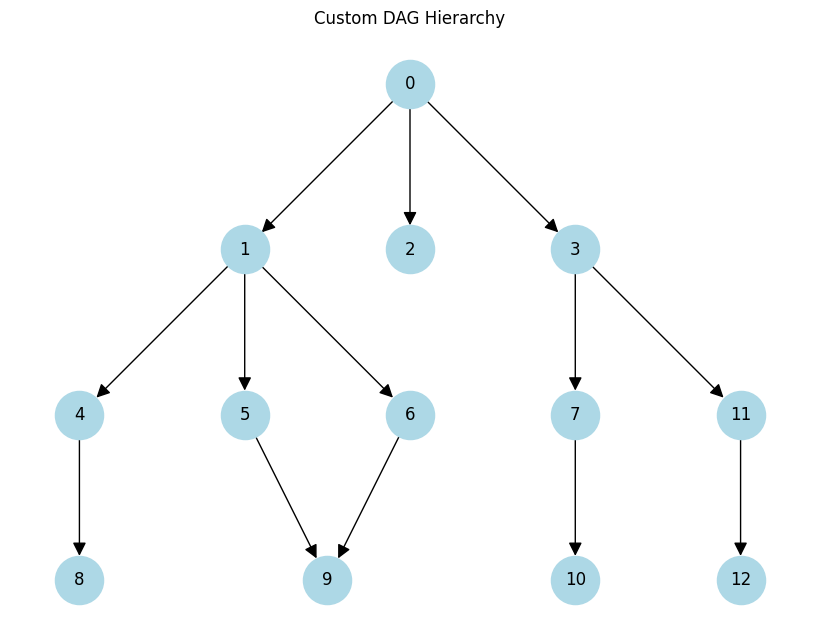

Reachability matrix:
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [2]:
labels = list(range(13))

edges = [
    (0, 1), (0, 2), (0, 3),
    (1, 4), (1, 5), (1, 6),
    # 2 is a leaf
    (3, 7), (3, 11),
    (4, 8),
    (5, 9),
    (6, 9),
    (7, 10),
    # 8 is a leaf
    # 9 is a leaf
    # 10 is a leaf
    (11, 12),
    # 12 is a leaf
]

G = nx.DiGraph()
G.add_nodes_from(labels)
G.add_edges_from(edges)

plt.figure(figsize=(8,6))
pos = graphviz_layout(G, prog="dot")
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1200, arrowsize=20)
plt.title("Custom DAG Hierarchy")
plt.show()

# Generate reachability matrix
n = len(labels)
reachability = np.zeros((n, n), dtype=np.float32)
for i in labels:
    reachable = nx.descendants(G, i)
    reachability[i, i] = 1  # node can reach itself
    for j in reachable:
        reachability[i, j] = 1

print("Reachability matrix:")
print(reachability)

## Synthetic dataset
We create a simple dataset where each class is a cluster in 2D space.

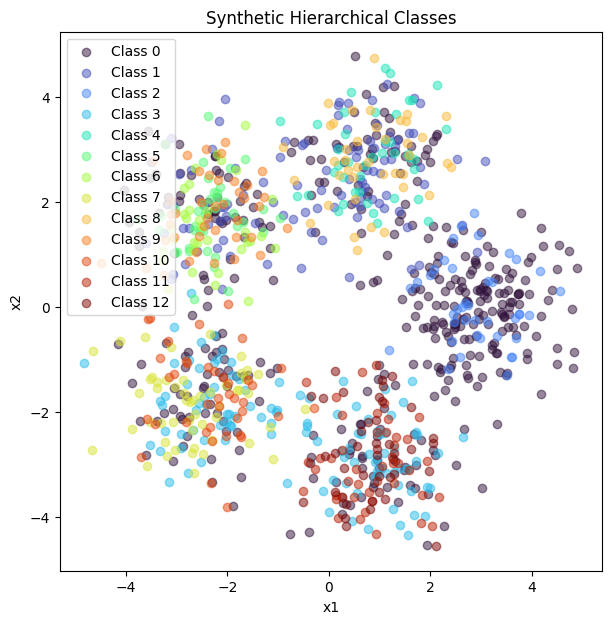

In [3]:
def make_synthetic_data(reachability, n_per_leaf=200, relabel_fraction=0.15, seed=0):
    np.random.seed(seed)
    # Find leaves: nodes that are only reachable from themselves
    is_leaf = (reachability.sum(axis=1) == 1)
    leaves = np.where(is_leaf)[0]

    # Arrange leaf centers in a circle for visualization
    angle = np.linspace(0, 2 * np.pi, len(leaves), endpoint=False)
    radius = 3
    leaf_centers = {leaf: [radius * np.cos(a), radius * np.sin(a)] for leaf, a in zip(leaves, angle)}

    # Generate samples for leaves
    X = []
    y = []
    for leaf in leaves:
        center = np.array(leaf_centers[leaf])
        X.append(center + 0.8 * np.random.randn(n_per_leaf, 2))
        y.append(np.full(n_per_leaf, leaf))
    X = np.vstack(X)
    y = np.concatenate(y)

    # For relabeling, keep track of original leaf for each sample
    sample_origins = y.copy()

    # For each leaf, relabel a fraction of its samples to one of its ancestors (excluding itself)
    for leaf in leaves:
        # Find ancestors: nodes from which leaf is reachable (excluding itself)
        ancestors = np.where(reachability[:, leaf] == 1)[0]
        ancestors = ancestors[ancestors != leaf]
        if len(ancestors) == 0:
            continue
        idx = np.where(sample_origins == leaf)[0]
        n_relabel = int(relabel_fraction * len(idx))
        if n_relabel > 0:
            relabel_idx = np.random.choice(idx, n_relabel, replace=False)
            # Randomly assign each relabeled sample to one of the ancestors
            new_labels = np.random.choice(ancestors, n_relabel, replace=True)
            y[relabel_idx] = new_labels

    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# Usage:
X, y = make_synthetic_data(reachability, n_per_leaf=200, relabel_fraction=0.8, seed=0)
plt.figure(figsize=(7,7))
n_classes = reachability.shape[0]
cmap = plt.get_cmap('turbo', n_classes)
for i in range(n_classes):
    plt.scatter(X[y==i,0], X[y==i,1], label=f'Class {i}', alpha=0.5, color=cmap(i))
plt.legend()
plt.title('Synthetic Hierarchical Classes')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

## Define models and loss functions

In [4]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
    def forward(self, x):
        return self.net(x)

def hierarchical_cross_entropy_loss(logits, targets, reachability_matrix, weight=None):
    cell_type_probs = torch.softmax(logits, dim=-1)
    cell_type_probs = torch.matmul(cell_type_probs, reachability_matrix.T)
    cell_type_probs = torch.log(cell_type_probs + 1e-6)
    return F.nll_loss(cell_type_probs, targets, weight=weight)


## Training loop

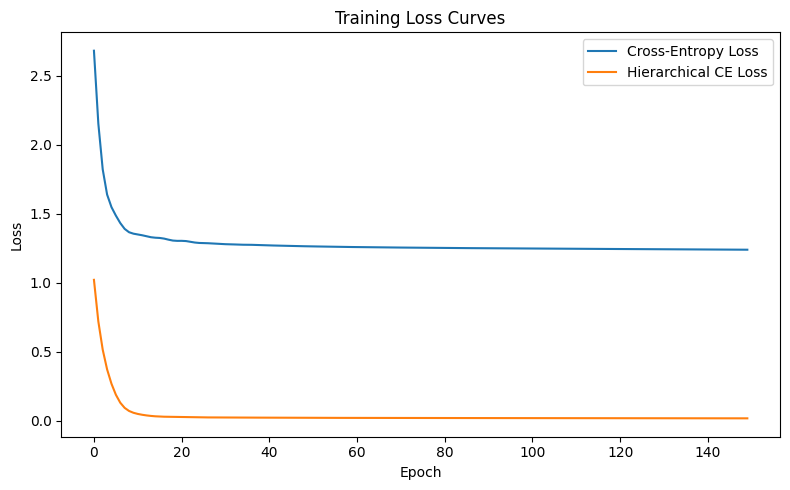

In [5]:
def train_model(model, loss_fn, X, y, epochs=150):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.03)
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        logits = model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return model, losses

n_classes = reachability.shape[0]
reachability_torch = torch.tensor(reachability, dtype=torch.float32)

# Train with standard CE
model_ce = SimpleMLP(2, n_classes)
ce_loss_fn = nn.CrossEntropyLoss()
model_ce, losses_ce = train_model(model_ce, ce_loss_fn, X, y)

# Train with HCE
model_hce = SimpleMLP(2, n_classes)
hce_loss_fn = lambda logits, targets: hierarchical_cross_entropy_loss(logits, targets, reachability_torch)
model_hce, losses_hce = train_model(model_hce, hce_loss_fn, X, y)

plt.figure(figsize=(8,5))
plt.plot(losses_ce, label='Cross-Entropy Loss')
plt.plot(losses_hce, label='Hierarchical CE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.tight_layout()
plt.show()


## Compare performance
Recall that a predicted label is considered correct if it exactly matches the ground-truth label or if it corresponds to a descendant of the ground-truth label in the reachability matrix.

In [6]:
def correct_labels(y_true: np.ndarray, y_pred: np.ndarray, child_matrix: np.ndarray):
    """
    If prediction is a child node of the true label, update prediction to true value.
    """
    updated_predictions = y_pred.copy()
    child_nodes = {i: np.where(child_matrix[i, :])[0] for i in range(child_matrix.shape[0])}
    for i, (pred, true_label) in enumerate(zip(y_pred, y_true)):
        if pred in child_nodes[true_label]:
            updated_predictions[i] = true_label
        else:
            updated_predictions[i] = pred
    return updated_predictions

with torch.no_grad():
    pred_ce = model_ce(X).argmax(1)
    pred_hce = model_hce(X).argmax(1)

y_np = y.numpy()
pred_ce_corr = correct_labels(y_np, pred_ce.numpy(), reachability)
pred_hce_corr = correct_labels(y_np, pred_hce.numpy(), reachability)
acc_ce_corr = accuracy_score(y_np, pred_ce_corr)
acc_hce_corr = accuracy_score(y_np, pred_hce_corr)
print(f'CE Accuracy: {acc_ce_corr:.3f}')
print(f'HCE Accuracy: {acc_hce_corr:.3f}')

CE Accuracy: 0.589
HCE Accuracy: 0.994


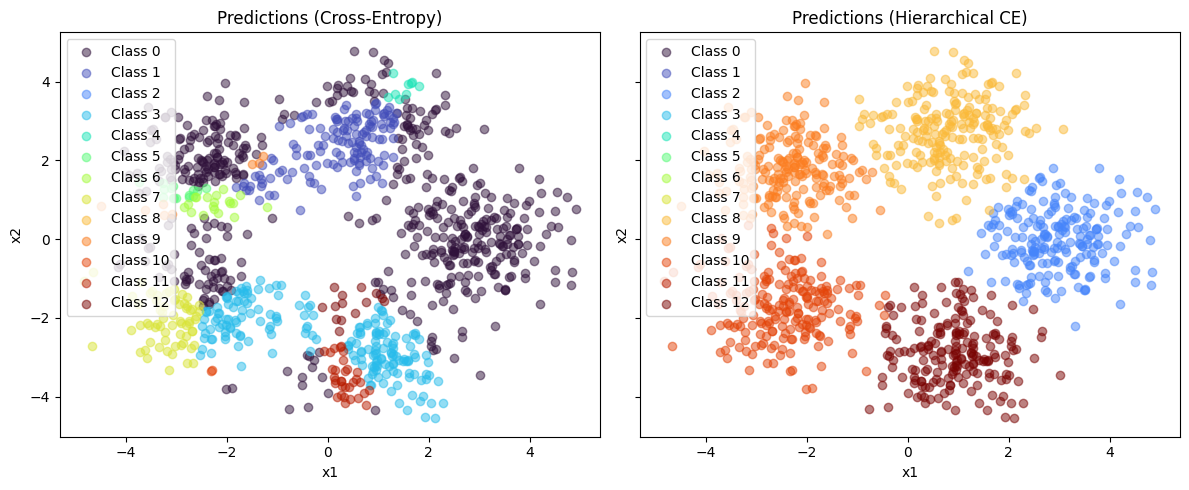

In [7]:
# Plot predictions for CE and HCE
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
titles = ['Predictions (Cross-Entropy)', 'Predictions (Hierarchical CE)']
preds = [pred_ce, pred_hce]

cmap = plt.get_cmap('turbo', n_classes)
for ax, pred, title in zip(axes, preds, titles):
    for i in range(n_classes):
        ax.scatter(X[pred==i, 0], X[pred==i, 1], label=f'Class {i}', alpha=0.5, color=cmap(i))
    ax.set_title(title)
    ax.legend()
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')

plt.tight_layout()
plt.show()